In [25]:
from keras.preprocessing.image import img_to_array,load_img
import numpy as np
import glob
import os 
import cv2
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imutils
from google.colab import drive
import time
import shutil                         
from keras.models import load_model
import argparse
from PIL import Image
from google.colab.patches import cv2_imshow


In [26]:
drive.mount ('/content/drive')
%cd /content/drive/MyDrive/Testfolder/training_videos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Testfolder/training_videos


In [27]:
ls -l

total 218933
-rw------- 1 root root 15842016 Jan  6  2014 01.avi
-rw------- 1 root root 16326258 Jan  6  2014 02.avi
-rw------- 1 root root 13095406 Jan  6  2014 03.avi
-rw------- 1 root root 15881174 Jan  6  2014 04.avi
-rw------- 1 root root  7156304 Jan  6  2014 05.avi
-rw------- 1 root root 12948348 Jan  6  2014 06.avi
-rw------- 1 root root 10497754 Jan  6  2014 07.avi
-rw------- 1 root root 10420502 Jan  6  2014 08.avi
-rw------- 1 root root 13496452 Jan  6  2014 09.avi
-rw------- 1 root root 11485388 Jan  6  2014 10.avi
-rw------- 1 root root  7489630 Jan  6  2014 11.avi
-rw------- 1 root root  2008118 Jan  6  2014 12.avi
-rw------- 1 root root  5448834 Jan  6  2014 13.avi
-rw------- 1 root root  5492610 Jan  6  2014 14.avi
-rw------- 1 root root  4277604 Jan  6  2014 15.avi
-rw------- 1 root root  3200890 Jan  6  2014 16.avi
-rw------- 1 root root   103716 May 30 06:09 1.mp4
-rw------- 1 root root   346112 Dec  7  2010 50_FIRST_DATES_dive_f_cm_np1_ri_bad_35.avi
-rw------- 1 roo

In [28]:
store_image=[]
train_path='/content/drive/MyDrive/Testfolder/training_videos'
fps=5
train_videos=os.listdir('/content/drive/MyDrive/Testfolder/training_videos')
train_images_path=train_path+'/frames'
# if the path given in the train_images_path already exists then it will be replaced
if os.path.exists(train_images_path):
    shutil.rmtree(train_images_path)
os.makedirs(train_images_path)

# store the frames in an array
def store_inarray(image_path):
    image=load_img(image_path)
    image=img_to_array(image)
    image=cv2.resize(image, (227,227), interpolation = cv2.INTER_AREA)
    gray=0.2989*image[:,:,0]+0.5870*image[:,:,1]+0.1140*image[:,:,2]
    store_image.append(gray)

#extract frames from the video and convert into jpg
for video in train_videos:
    os.system( 'ffmpeg -i {}/{} -r 1/{}  {}/frames/%03d.jpg'.format(train_path,video,fps,train_path))
    images=os.listdir(train_images_path)
    for image in images:
        image_path=train_images_path + '/' + image
        store_inarray(image_path)

In [29]:
#Store the store_image list in a numpy file “training.npy"
store_image=np.array(store_image)
a,b,c=store_image.shape

store_image.resize(b,c,a)
store_image=(store_image-store_image.mean())/(store_image.std())
store_image=np.clip(store_image,0,1)
np.save('training.npy',store_image)

In [30]:
#Create spatial autoencoder architecture
# [An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning).
# The encoding is validated and refined by attempting to regenerate the input from the encoding. The autoencoder learns a representation (encoding) for a set of data, 
# typically for dimensionality reduction, by training the network to ignore insignificant data (“noise”). ]
stae_model=Sequential()

stae_model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
stae_model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))
stae_model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))
stae_model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
stae_model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

stae_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [31]:
#Train the autoencoder on the “training.npy” file and save the model with name “saved_model.h5”
training_data=np.load('training.npy')
frames=training_data.shape[2]
frames=frames-frames%10

#dataset_size = encoded.shape[0]

training_data=training_data[:,:,:frames]
training_data=training_data.reshape(-1,227,227,10)
training_data=np.expand_dims(training_data,axis=4)
target_data=training_data.copy()

epochs=5
batch_size=1

callback_save = ModelCheckpoint("saved_model.h5", monitor="mean_squared_error", save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#stae_model.add(Conv3D(input_shape = (227,227,10), filters = 8, kernel_size = (5,5,5),activation = "relu", padding = "same" ))
stae_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_crossentropy'],run_eagerly=True)



#stae_model.fit(training_data,target_data, batch_size=batch_size, epochs=epochs, callbacks = [callback_save,callback_early_stopping])
stae_model.save("saved_model.h5")

True

Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.0007438208496320368
Abnormal Event Detected
0.00

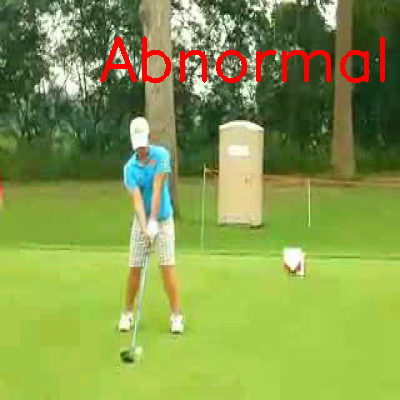

True

Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.0007427487723747608
Abnormal Event Detected
0.00

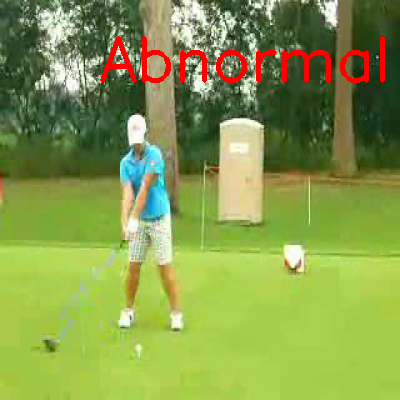

True

Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.0007395006579401024
Abnormal Event Detected
0.00

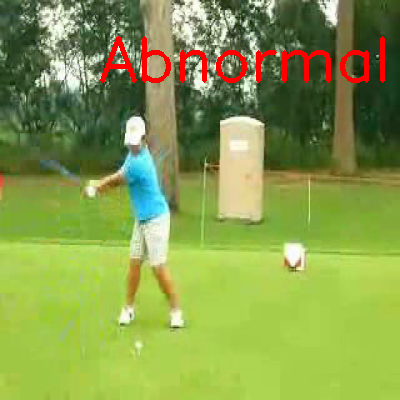

True

Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.0007335872123927423
Abnormal Event Detected
0.00

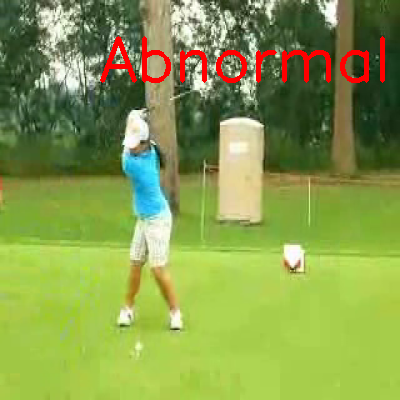

True

Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.0007366213643029965
Abnormal Event Detected
0.00

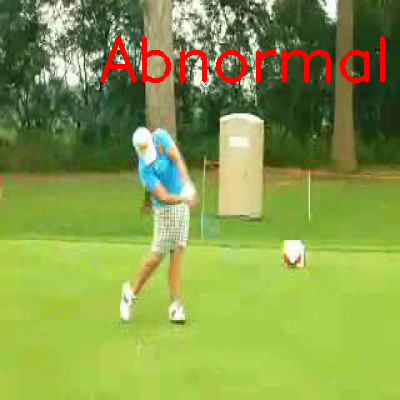

True

Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.0007364936275234928
Abnormal Event Detected
0.00

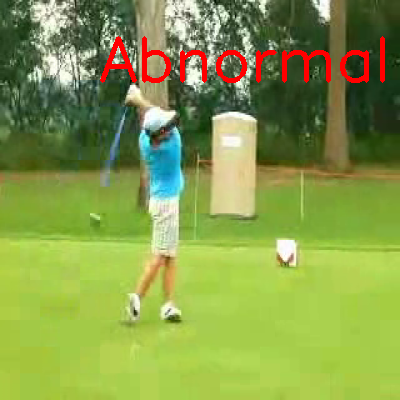

True

Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.0007382764193519231
Abnormal Event Detected
0.00

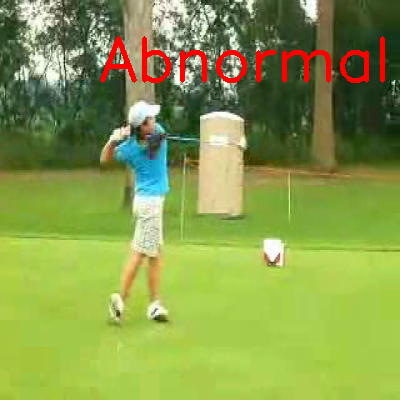

In [32]:
alex = []
def mean_squared_loss(x1,x2):
    difference=x1-x2
    a,b,c,d,e=difference.shape
    n_samples=a*b*c*d*e
    sq_difference=difference**2
    Sum=sq_difference.sum()
    distance=np.sqrt(Sum)
    mean_distance=distance/n_samples

    return mean_distance

os.chdir('/content/drive/MyDrive/Testfolder/training_videos') #changes directory

model=load_model("saved_model.h5")

os.chdir('/content/drive/MyDrive/Testfolder/training_videos')

cap = cv2.VideoCapture("/content/drive/MyDrive/Testfolder/training_videos/Ariya_Swing_golf_f_cm_np1_fr_bad_0.avi")

#print(cap.isOpened())


while cap.isOpened():
    imagedump=[]
    ret,frame=cap.read()

    for i in range(10):
        ret,frame=cap.read()
        
        if frame is None:
          break

        image =cv2.resize(frame,(400,400), interpolation=cv2.INTER_AREA) 
      
        frame=cv2.resize(frame, (227,227), interpolation = cv2.INTER_AREA)
        gray=0.2989*frame[:,:,0]+0.5870*frame[:,:,1]+0.1140*frame[:,:,2]
        gray=(gray-gray.mean())/gray.std()
        gray=np.clip(gray,0,1)
        imagedump.append(gray)

    imagedump=np.array(imagedump)

    imagedump.resize(227,227,10)
    imagedump=np.expand_dims(imagedump,axis=0)
    imagedump=np.expand_dims(imagedump,axis=4)

    output=model.predict(imagedump)

    loss=mean_squared_loss(imagedump,output)

    if frame is None:
       break
    elif(frame.any()==None):
       print("none")

    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
    if loss>0.00068:
        print("True\n")
        for i in frame:
          print('Abnormal Event Detected')
          print(loss)
        cv2.putText(image,'Abnormal Event',(100,80),cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),4)
        cv2_imshow(image)
        alex.append(image)
    else:
      print("False")

cap.release()
cv2.destroyAllWindows()

In [33]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import gradio as gr
import sys

In [35]:
flag = len(alex)
print(flag)

7


In [36]:
import gradio as gr

def greet(name, is_morning, temperature):
    flag=0
    
    for image in alex:
      if(flag==0):
       im=image
      else:
       im = cv2.vconcat([im, image]) #vertical concatination
      flag+=1
    if is_morning: 
       salutation = "Good morning" 
    else:
       salutation="ato abnormal frame cholbena"
    #greeting = "degrees today %s %s" % (salutation,temperature)
    celsius = (temperature - 32) * 5 / 9
    return round(celsius, 2),im 

demo = gr.Interface(
    fn=greet,
    inputs=["text", "checkbox", gr.Slider(0, 212)],
    outputs=[ "number","image"], 
)
demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://13672.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f743567efd0>,
 'http://127.0.0.1:7864/',
 'https://13672.gradio.app')

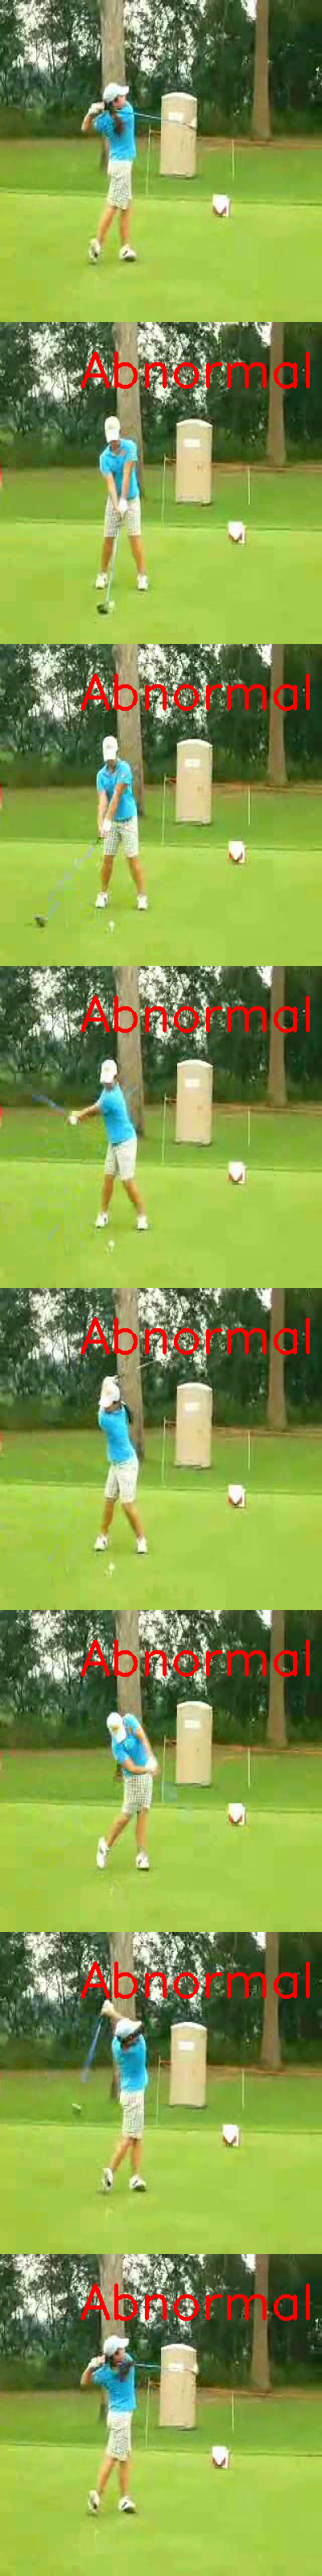

In [37]:
im=image
for image in alex:
 im = cv2.vconcat([im, image])
cv2_imshow(im)